In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__file__)

from tensorflow.keras import layers, models
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_path = Path("data/Training")
test_path = Path("data/Testing")

2.16.2
/Users/faridgahramanov/miniconda3/lib/python3.12/site-packages/keras/_tf_keras/keras/__init__.py


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 3052 files belonging to 2 classes.


2025-06-20 12:12:13.243557: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-20 12:12:13.243593: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-20 12:12:13.243596: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-20 12:12:13.243630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-20 12:12:13.243643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 705 files belonging to 2 classes.


In [3]:
rescale_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale_layer(x), y))
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model = models.Sequential([
    layers.InputLayer(shape = (224,224,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') 
])

In [10]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=2
)

Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7279 - auc_1: 0.8227 - loss: 0.6077 - precision_1: 0.7740 - recall_1: 0.5895 - val_accuracy: 0.9830 - val_auc_1: 0.9975 - val_loss: 0.0524 - val_precision_1: 0.9768 - val_recall_1: 0.9833
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9633 - auc_1: 0.9918 - loss: 0.1051 - precision_1: 0.9575 - recall_1: 0.9693 - val_accuracy: 0.9858 - val_auc_1: 0.9996 - val_loss: 0.0364 - val_precision_1: 0.9708 - val_recall_1: 0.9967


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())
    
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["notumor", "tumor"]))

# Confusion matrix
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# F1-score
print("🎯 F1 Score:", f1_score(y_true, y_pred))

# R² score (optional)
print("📉 R² Score:", r2_score(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📊 Classification Report:
              precision    recall  f1-score   support

     notumor       1.00      0.98      0.99   

2025-06-20 12:14:13.355999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 3052 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


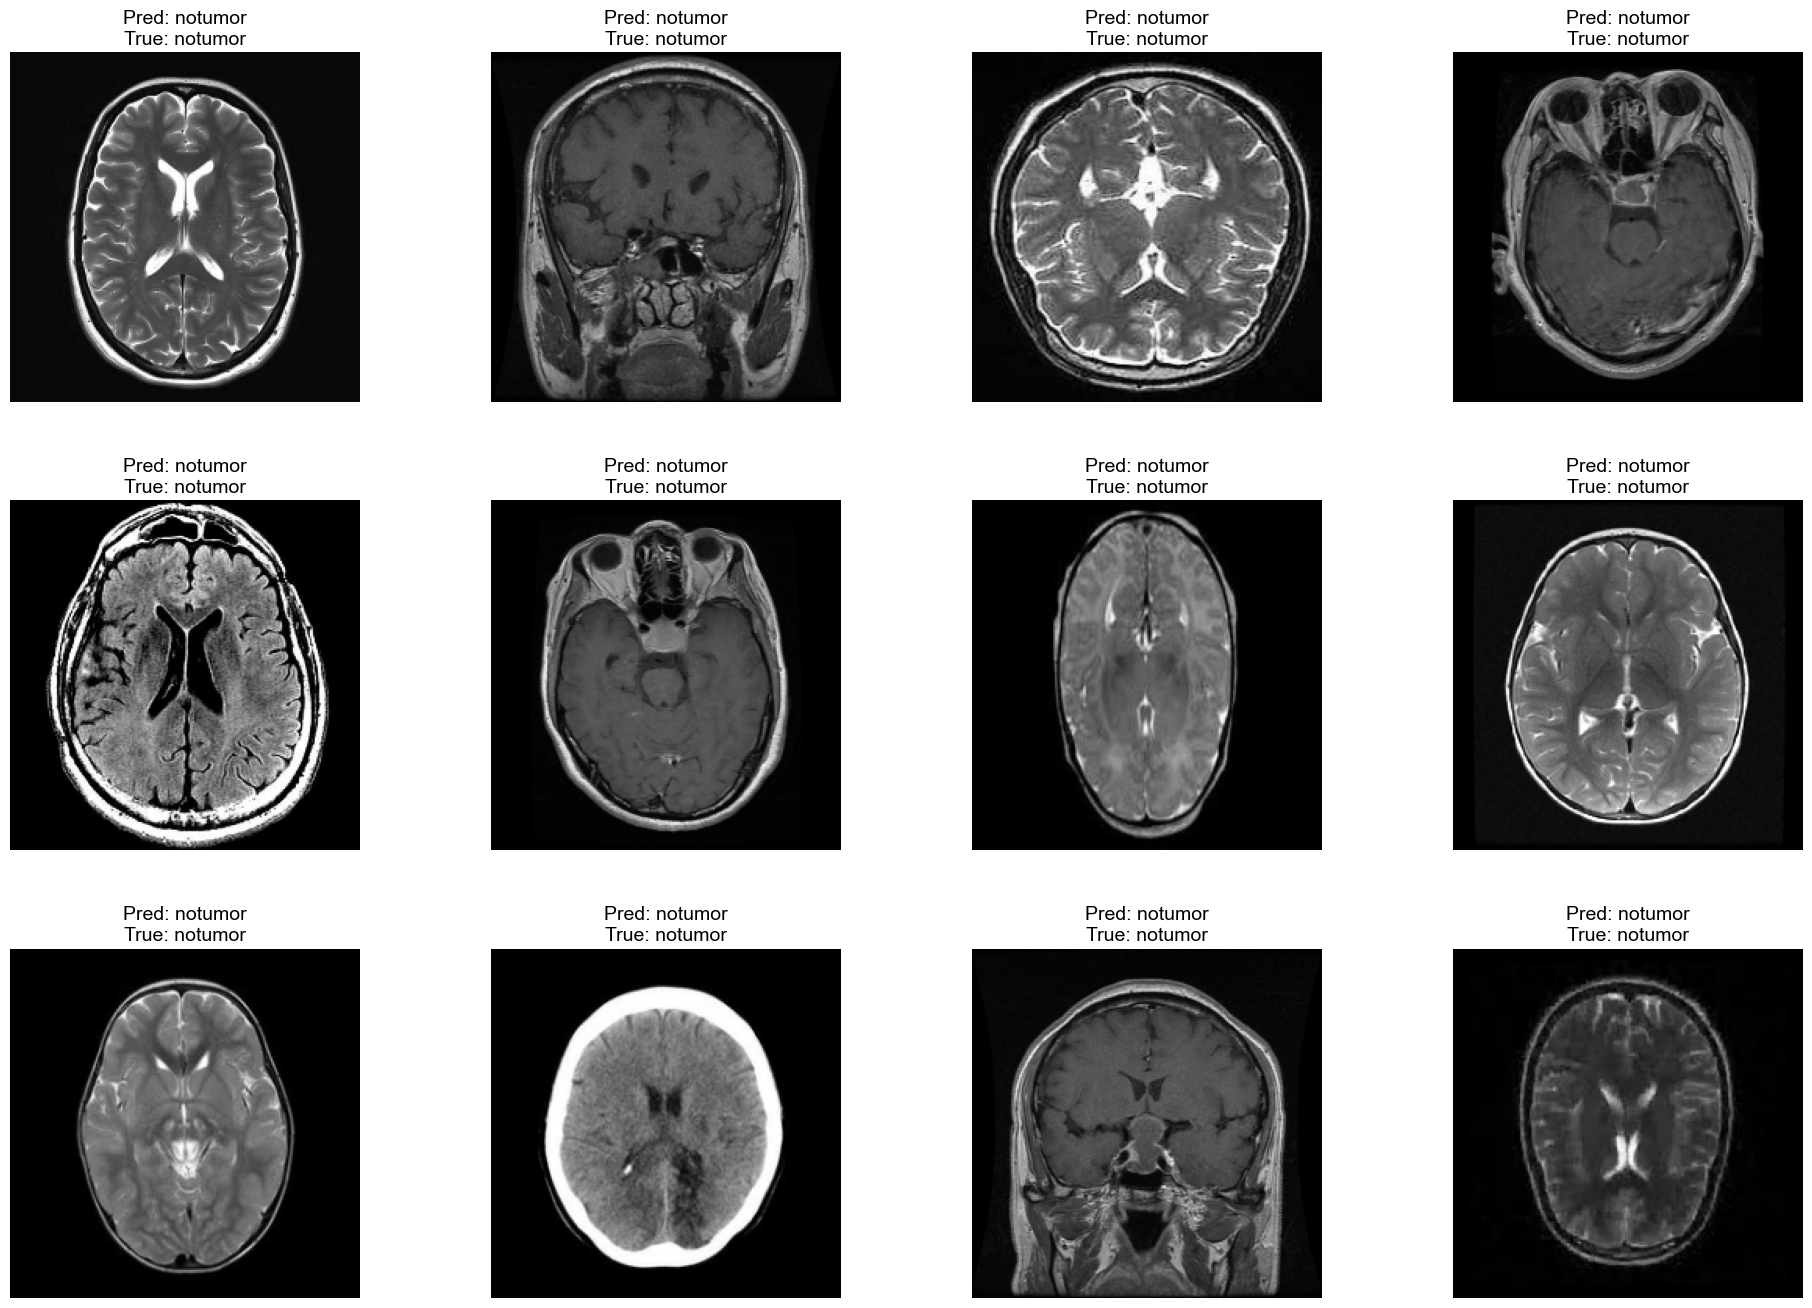

2025-06-20 12:16:03.361328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/Training",
    labels='inferred',
    label_mode='binary',  # One-hot for multiclass
    image_size=(224, 224),
    batch_size=32
)
class_names = raw_train_ds.class_names

# Visualize predictions
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    plt.figure(figsize=(20, 14))
    for i in range(min(12, len(images))):
        ax = plt.subplot(3, 4, i + 1)
        
        # Convert and clip for proper display
        img_np = images[i].numpy()
        img_np = np.clip(img_np, 0.0, 1.0)
        plt.imshow(img_np, cmap='gray')  # Use grayscale mode

        plt.title(
            f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[true_classes[i]]}",
            fontsize=14,
            color='black'
        )
        plt.axis("off")
    plt.tight_layout(pad=4.0)
    plt.show()

In [15]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/categorical_train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'  # Important: for one-hot encoding
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/categorical_test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 4117 files belonging to 3 classes.
Found 906 files belonging to 3 classes.
Classes: ['glioma', 'meningioma', 'pituitary1']


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [20]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base

categorical_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

categorical_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [21]:
history = categorical_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.6176 - loss: 1.0859 - val_accuracy: 0.8742 - val_loss: 0.3308
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8308 - loss: 0.5399 - val_accuracy: 0.8808 - val_loss: 0.3587
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8584 - loss: 0.4315 - val_accuracy: 0.8974 - val_loss: 0.2940
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8831 - loss: 0.3402 - val_accuracy: 0.9051 - val_loss: 0.2774
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9006 - loss: 0.2782 - val_accuracy: 0.9029 - val_loss: 0.2677


In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = categorical_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

2025-06-20 12:29:41.455815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


In [24]:
test_dir = "data/categorical_test"
class_names = ['glioma', 'meningioma', 'pituitary1']
img_size = (224, 224)


In [27]:
def predict_random_images(model, test_dir, class_names, num_images=6):
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        # Random class folder
        class_choice = random.choice(class_names)
        class_path = os.path.join(test_dir, class_choice)
        
        # Random image from that class
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        # Load and preprocess
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_expanded = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_expanded)
        predicted_class = class_names[np.argmax(prediction)]

        # Plot
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}\nActual: {class_choice}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


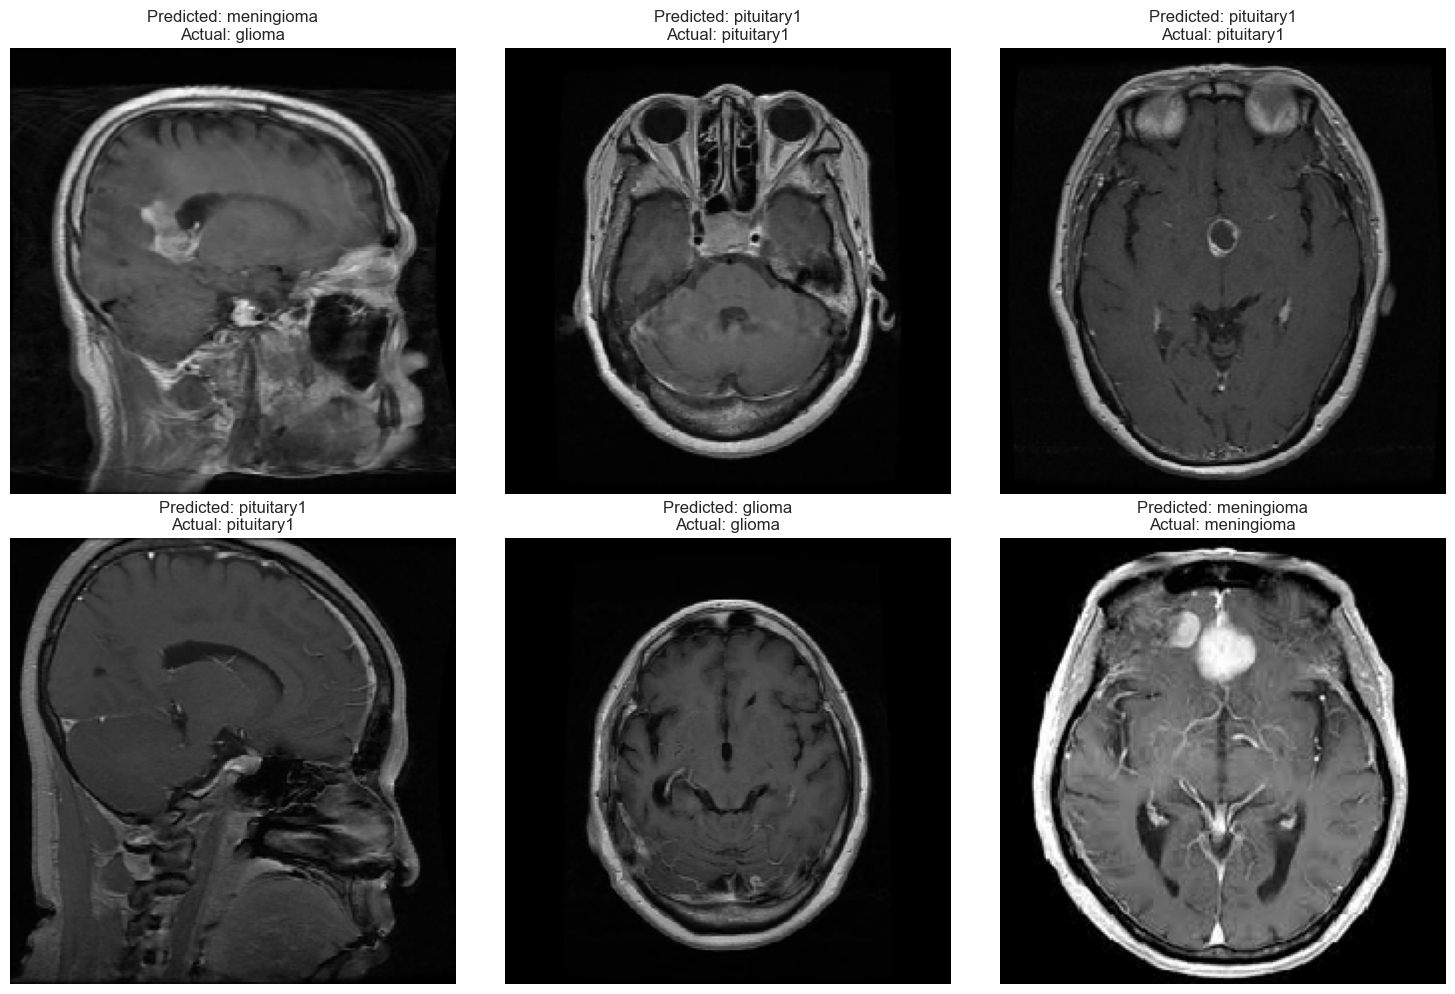

In [28]:
predict_random_images(categorical_model, test_dir, class_names)
